In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Text to Speech Using Transformer Architecture

## Hyperperemeter Class

**he Hyperparams class contains all the necessary parameters for configuring the text-to-speech model. These parameters include file paths, text and sound transformation settings, model architecture details, and training configurations.**

* File Paths: Paths for input CSV files, waveform data, saving models, and logging.
* Text Transformations: List of symbols used for text preprocessing and their mapping.
* Sound Transformations: Sample rate, FFT parameters, mel frequency bins, decibel scaling, etc.
* Model Parameters: Embedding sizes, kernel sizes, and other architecture-related settings.
* Training Parameters: Batch size, gradient clipping value, learning rate, and steps for logging, testing, and saving.

In [2]:
class Hyperparams:
  seed = 42

  csv_path = "/content/drive/MyDrive/Text_to_Speech/LJSpeech-1.1/metadata.csv"
  wav_path = "/content/drive/MyDrive/Text_to_Speech/LJSpeech-1.1/wavs"
  save_path = "/content/drive/MyDrive/Text_to_Speech/params"
  log_path = "/content/drive/MyDrive/Text_to_Speech/train_logs"

  save_name = "SimpleTransfromerTTS.pt"

  # Text transformations params
  symbols = [
    'EOS', ' ', '!', ',', '-', '.', \
    ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', \
    'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
    'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', \
    'â', 'è', 'é', 'ê', 'ü', '’', '“', '”' \
  ]

  # Sounds transformations params
  sr = 22050
  n_fft = 2048
  n_stft = int((n_fft//2) + 1)

  frame_shift = 0.0125 # seconds
  hop_length = int(n_fft/8.0)

  frame_length = 0.05 # seconds
  win_length = int(n_fft/2.0)

  mel_freq = 128
  max_mel_time = 1024

  max_db = 100
  scale_db = 10
  ref = 4.0
  power = 2.0
  norm_db = 10
  ampl_multiplier = 10.0
  ampl_amin = 1e-10
  db_multiplier = 1.0
  ampl_ref = 1.0
  ampl_power = 1.0

  # Model params
  text_num_embeddings = 2*len(symbols)
  embedding_size = 256
  encoder_embedding_size = 512

  dim_feedforward = 1024
  postnet_embedding_size = 1024

  encoder_kernel_size = 3
  postnet_kernel_size = 5

  # Other
  batch_size = 32
  grad_clip = 1.0
  lr = 2.0 * 1e-4
  r_gate = 1.0

  step_print = 1000
  step_test = 8000
  step_save = 8000

hp = Hyperparams()

if __name__ == "__main__":
  print(hp.symbols)
  print(len(hp.symbols))


hp = Hyperparams()

['EOS', ' ', '!', ',', '-', '.', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'è', 'é', 'ê', 'ü', '’', '“', '”']
43


In [3]:
hp.csv_path

'/content/drive/MyDrive/Text_to_Speech/LJSpeech-1.1/metadata.csv'

## Mask from Sequence Lengths Function

**This function creates a mask tensor for a batch of sequences with different lengths.**

* **Purpose**: To create a mask that identifies valid positions within each sequence in a batch, useful for padding sequences in deep learning models.
* **Input**: A tensor containing sequence lengths and the maximum sequence length.
* **Output**: A boolean mask tensor where positions with valid data are marked as True and padding positions are False.

In [4]:
import torch
import torch
symbol_to_id = {
  s: i for i, s in enumerate(hp.symbols)
}

def mask_from_seq_lengths(
    sequence_lengths: torch.Tensor,
    max_length: int
) -> torch.BoolTensor:
    """
    our input was `[2, 2, 3]`, with a `max_length` of 4, we'd return
    `[[1, 1, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0]]`.
    """
    # (batch_size, max_length)
    ones = sequence_lengths.new_ones(sequence_lengths.size(0), max_length)
    range_tensor = ones.cumsum(dim=1)
    return sequence_lengths.unsqueeze(1) >= range_tensor

## Text to Sequence Conversion

* **Purpose**: To convert text into a format suitable for input into a neural network.
* **Input**: A string of text.
* **Output**: A tensor of integer IDs corresponding to the symbols in the text.

In [5]:
import torch

symbol_to_id = {
  s: i for i, s in enumerate(hp.symbols)
}

def text_to_seq(text):
  text = text.lower()
  seq = []
  for s in text:
    _id = symbol_to_id.get(s, None)
    if _id is not None:
      seq.append(_id)

  seq.append(symbol_to_id["EOS"])

  return torch.IntTensor(seq)


if __name__ == "__main__":
  print(text_to_seq("Hello, World"))

tensor([15, 12, 19, 19, 22,  3,  1, 30, 22, 25, 19, 11,  0], dtype=torch.int32)


## Audio Processing

**These functions handle the conversion between waveform and mel spectrogram, including normalization and denormalization.**

1. **Spectrogram Transformation**: Converts waveform to spectrogram.
2. **Mel Scale Transformation**: Converts spectrogram to mel spectrogram.
3. **Inverse Mel Scale Transformation**: Converts mel spectrogram back to spectrogram.
4. **Griffin-Lim Transformation**: Converts spectrogram back to waveform.
5. **Normalization**: Normalizes mel spectrogram to a specific range.
6. **Denormalization**: Converts normalized mel spectrogram back to original scale.
7. **Power to dB Conversion**: Converts mel spectrogram from power to decibel scale.
8. **dB to Power Conversion**: Converts mel spectrogram from decibel to power scale.

In [6]:
import torch
import torchaudio
from torchaudio.functional import spectrogram


spec_transform = torchaudio.transforms.Spectrogram(
    n_fft=hp.n_fft,
    win_length=hp.win_length,
    hop_length=hp.hop_length,
    power=hp.power
)


mel_scale_transform = torchaudio.transforms.MelScale(
  n_mels=hp.mel_freq,
  sample_rate=hp.sr,
  n_stft=hp.n_stft
)


mel_inverse_transform = torchaudio.transforms.InverseMelScale(
  n_mels=hp.mel_freq,
  sample_rate=hp.sr,
  n_stft=hp.n_stft
).cuda()


griffnlim_transform = torchaudio.transforms.GriffinLim(
    n_fft=hp.n_fft,
    win_length=hp.win_length,
    hop_length=hp.hop_length
).cuda()


def norm_mel_spec_db(mel_spec):
  mel_spec = ((2.0*mel_spec - hp.min_level_db) / (hp.max_db/hp.norm_db)) - 1.0
  mel_spec = torch.clip(mel_spec, -hp.ref*hp.norm_db, hp.ref*hp.norm_db)
  return mel_spec


def denorm_mel_spec_db(mel_spec):
  mel_spec = (((1.0 + mel_spec) * (hp.max_db/hp.norm_db)) + hp.min_level_db) / 2.0
  return mel_spec


def pow_to_db_mel_spec(mel_spec):
  mel_spec = torchaudio.functional.amplitude_to_DB(
    mel_spec,
    multiplier = hp.ampl_multiplier,
    amin = hp.ampl_amin,
    db_multiplier = hp.db_multiplier,
    top_db = hp.max_db
  )
  mel_spec = mel_spec/hp.scale_db
  return mel_spec


def db_to_power_mel_spec(mel_spec):
  mel_spec = mel_spec*hp.scale_db
  mel_spec = torchaudio.functional.DB_to_amplitude(
    mel_spec,
    ref=hp.ampl_ref,
    power=hp.ampl_power
  )
  return mel_spec


def convert_to_mel_spec(wav):
  spec = spec_transform(wav)
  mel_spec = mel_scale_transform(spec)
  db_mel_spec = pow_to_db_mel_spec(mel_spec)
  db_mel_spec = db_mel_spec.squeeze(0)
  return db_mel_spec


def inverse_mel_spec_to_wav(mel_spec):
  power_mel_spec = db_to_power_mel_spec(mel_spec)
  spectrogram = mel_inverse_transform(power_mel_spec)
  pseudo_wav = griffnlim_transform(spectrogram)
  return pseudo_wav


if __name__ == "__main__":
  wav_path = '/content/drive/MyDrive/Text_to_Speech/LJSpeech-1.1/wavs/LJ001-0007.wav'
  waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
  mel_spec = convert_to_mel_spec(waveform)
  print("mel_spec:", mel_spec.shape)

  pseudo_wav = inverse_mel_spec_to_wav(mel_spec.cuda())
  print("pseudo_wav:", pseudo_wav.shape)

mel_spec: torch.Size([128, 723])
pseudo_wav: torch.Size([184832])


In [7]:
import torch

symbol_to_id = {
  s: i for i, s in enumerate(hp.symbols)
}

def text_to_seq(text):
  text = text.lower()
  seq = []
  for s in text:
    _id = symbol_to_id.get(s, None)
    if _id is not None:
      seq.append(_id)

  seq.append(symbol_to_id["EOS"])

  return torch.IntTensor(seq)


if __name__ == "__main__":
  print(text_to_seq("Hello, World"))

tensor([15, 12, 19, 19, 22,  3,  1, 30, 22, 25, 19, 11,  0], dtype=torch.int32)


In [8]:
import torch
import torchaudio
import pandas as pd

class TextMelDataset(torch.utils.data.Dataset):
    """
    A custom Dataset for loading text and mel-spectrogram pairs.

    This dataset loads text and audio data, converts audio to mel-spectrograms,
    and caches the results for faster subsequent access.

    Attributes:
        df (pandas.DataFrame): DataFrame containing metadata about the dataset.
        cache (dict): A cache to store processed items.
    """

    def __init__(self, df):
        """
        Initialize the dataset.

        Args:
            df (pandas.DataFrame): DataFrame containing 'wav' and 'text_norm' columns.
        """
        self.df = df
        self.cache = {}

    def get_item(self, row):
        """
        Process a single row of the dataset.

        Args:
            row (pandas.Series): A row from the dataset DataFrame.

        Returns:
            tuple: Processed (text, mel-spectrogram) pair.
        """
        wav_id = row["wav"]
        wav_path = f"{hp.wav_path}/{wav_id}.wav"
        text = row["text_norm"]
        text = text_to_seq(text)
        waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
        assert sample_rate == hp.sr
        mel = convert_to_mel_spec(waveform)
        return (text, mel)

    def __getitem__(self, index):
        """
        Get a single item from the dataset.

        This method implements caching to speed up repeated access to the same item.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            tuple: Processed (text, mel-spectrogram) pair.
        """
        row = self.df.iloc[index]
        wav_id = row["wav"]
        text_mel = self.cache.get(wav_id)
        if text_mel is None:
            text_mel = self.get_item(row)
            self.cache[wav_id] = text_mel

        return text_mel

    def __len__(self):
        """
        Get the total number of items in the dataset.

        Returns:
            int: Number of items in the dataset.
        """
        return len(self.df)

def text_mel_collate_fn(batch):
    """
    Collate function for creating batches of data.

    This function pads sequences to a consistent length within each batch.

    Args:
        batch (list): List of (text, mel-spectrogram) pairs.

    Returns:
        tuple: Batched and padded tensors (text, text lengths, mel-spectrograms, mel lengths, stop tokens).
    """
    text_length_max = torch.tensor(
        [text.shape[-1] for text, _ in batch],
        dtype=torch.int32
    ).max()
    mel_length_max = torch.tensor(
        [mel.shape[-1] for _, mel in batch],
        dtype=torch.int32
    ).max()

    text_lengths = []
    mel_lengths = []
    texts_padded = []
    mels_padded = []
    for text, mel in batch:
        text_length = text.shape[-1]
        text_padded = torch.nn.functional.pad(
            text,
            pad=[0, text_length_max-text_length],
            value=0
        )
        mel_length = mel.shape[-1]
        mel_padded = torch.nn.functional.pad(
            mel,
            pad=[0, mel_length_max-mel_length],
            value=0
        )
        text_lengths.append(text_length)
        mel_lengths.append(mel_length)
        texts_padded.append(text_padded)
        mels_padded.append(mel_padded)
    text_lengths = torch.tensor(text_lengths, dtype=torch.int32)
    mel_lengths = torch.tensor(mel_lengths, dtype=torch.int32)
    texts_padded = torch.stack(texts_padded, 0)
    mels_padded = torch.stack(mels_padded, 0).transpose(1, 2)
    stop_token_padded = mask_from_seq_lengths(
        mel_lengths,
        mel_length_max
    )
    stop_token_padded = (~stop_token_padded).float()
    stop_token_padded[:, -1] = 1.0

    return texts_padded, \
           text_lengths, \
           mels_padded, \
           mel_lengths, \
           stop_token_padded

if __name__ == "__main__":
    hp = Hyperparams()
    df = pd.read_csv(hp.csv_path)
    dataset = TextMelDataset(df)
    train_loader = torch.utils.data.DataLoader(
        dataset,
        num_workers=2,
        shuffle=True,
        sampler=None,
        batch_size=hp.batch_size,
        pin_memory=True,
        drop_last=True,
        collate_fn=text_mel_collate_fn
    )

    def names_shape(names, shape):
        """
        Create a formatted string of tensor names and shapes.

        Args:
            names (list): List of dimension names.
            shape (tuple): Shape of the tensor.

        Returns:
            str: Formatted string of names and shapes.
        """
        assert len(names) == len(shape)
        return "(" + ", ".join([f"{k}={v}" for k, v in list(zip(names, shape))]) + ")"

    # Example usage and shape printing
    for i, batch in enumerate(train_loader):
        text_padded, \
        text_lengths, \
        mel_padded, \
        mel_lengths, \
        stop_token_padded = batch
        print(f"=========batch {i}=========")
        print("text_padded:", names_shape(["N", "S"], text_padded.shape))
        print("text_lengths:", names_shape(["N"], text_lengths.shape))
        print("mel_padded:", names_shape(["N", "TIME", "FREQ"], mel_padded.shape))
        print("mel_lengths:", names_shape(["N"], mel_lengths.shape))
        print("stop_token_padded:", names_shape(["N", "TIME"], stop_token_padded.shape))
        if i > 0:
            break


=========batch 0=========
text_padded: (N=32, S=145)
text_lengths: (N=32)
mel_padded: (N=32, TIME=791, FREQ=128)
mel_lengths: (N=32)
stop_token_padded: (N=32, TIME=791)
=========batch 1=========
text_padded: (N=32, S=154)
text_lengths: (N=32)
mel_padded: (N=32, TIME=849, FREQ=128)
mel_lengths: (N=32)
stop_token_padded: (N=32, TIME=849)


In [9]:
import math
import torch
import torch.nn.functional as F
import torch.nn as nn

import pandas as pd
from tqdm import tqdm

# https://github.com/NVIDIA/tacotron2/blob/master/model.py
# https://github.com/NVIDIA/tacotron2/blob/master/layers.py

class EncoderBlock(nn.Module):
    """
    Represents a single encoder block in the Transformer architecture.

    This block consists of self-attention followed by a feedforward network,
    with layer normalization and residual connections.
    """

    def __init__(self):
        """
        Initialize the EncoderBlock with its layers.
        """
        super(EncoderBlock, self).__init__()
        self.norm_1 = nn.LayerNorm(normalized_shape=hp.embedding_size)
        self.attn = torch.nn.MultiheadAttention(
            embed_dim=hp.embedding_size,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )
        self.dropout_1 = torch.nn.Dropout(0.1)
        self.norm_2 = nn.LayerNorm(normalized_shape=hp.embedding_size)
        self.linear_1 = nn.Linear(hp.embedding_size, hp.dim_feedforward)
        self.dropout_2 = torch.nn.Dropout(0.1)
        self.linear_2 = nn.Linear(hp.dim_feedforward, hp.embedding_size)
        self.dropout_3 = torch.nn.Dropout(0.1)

    def forward(self, x, attn_mask=None, key_padding_mask=None):
        """
        Forward pass of the EncoderBlock.

        Args:
            x (Tensor): Input tensor
            attn_mask (Tensor, optional): Attention mask
            key_padding_mask (Tensor, optional): Key padding mask

        Returns:
            Tensor: Output tensor after passing through the encoder block
        """
        x_out = self.norm_1(x)
        x_out, _ = self.attn(
            query=x_out,
            key=x_out,
            value=x_out,
            attn_mask=attn_mask,
            key_padding_mask=key_padding_mask
        )
        x_out = self.dropout_1(x_out)
        x = x + x_out

        x_out = self.norm_2(x)
        x_out = self.linear_1(x_out)
        x_out = F.relu(x_out)
        x_out = self.dropout_2(x_out)
        x_out = self.linear_2(x_out)
        x_out = self.dropout_3(x_out)
        x = x + x_out

        return x

class DecoderBlock(nn.Module):
    """
    Represents a single decoder block in the Transformer architecture.

    This block consists of self-attention, encoder-decoder attention, and a feedforward network,
    with layer normalization and residual connections.
    """

    def __init__(self):
        """
        Initialize the DecoderBlock with its layers.
        """
        super(DecoderBlock, self).__init__()
        self.norm_1 = nn.LayerNorm(normalized_shape=hp.embedding_size)
        self.self_attn = torch.nn.MultiheadAttention(
            embed_dim=hp.embedding_size,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )
        self.dropout_1 = torch.nn.Dropout(0.1)
        self.norm_2 = nn.LayerNorm(normalized_shape=hp.embedding_size)
        self.attn = torch.nn.MultiheadAttention(
            embed_dim=hp.embedding_size,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )
        self.dropout_2 = torch.nn.Dropout(0.1)
        self.norm_3 = nn.LayerNorm(normalized_shape=hp.embedding_size)
        self.linear_1 = nn.Linear(hp.embedding_size, hp.dim_feedforward)
        self.dropout_3 = torch.nn.Dropout(0.1)
        self.linear_2 = nn.Linear(hp.dim_feedforward, hp.embedding_size)
        self.dropout_4 = torch.nn.Dropout(0.1)

    def forward(self, x, memory, x_attn_mask=None, x_key_padding_mask=None,
                memory_attn_mask=None, memory_key_padding_mask=None):
        """
        Forward pass of the DecoderBlock.

        Args:
            x (Tensor): Input tensor
            memory (Tensor): Encoder output
            x_attn_mask (Tensor, optional): Self-attention mask
            x_key_padding_mask (Tensor, optional): Self-attention key padding mask
            memory_attn_mask (Tensor, optional): Encoder-decoder attention mask
            memory_key_padding_mask (Tensor, optional): Encoder-decoder key padding mask

        Returns:
            Tensor: Output tensor after passing through the decoder block
        """
        x_out, _ = self.self_attn(
            query=x,
            key=x,
            value=x,
            attn_mask=x_attn_mask,
            key_padding_mask=x_key_padding_mask
        )
        x_out = self.dropout_1(x_out)
        x = self.norm_1(x + x_out)

        x_out, _ = self.attn(
            query=x,
            key=memory,
            value=memory,
            attn_mask=memory_attn_mask,
            key_padding_mask=memory_key_padding_mask
        )
        x_out = self.dropout_2(x_out)
        x = self.norm_2(x + x_out)

        x_out = self.linear_1(x)
        x_out = F.relu(x_out)
        x_out = self.dropout_3(x_out)
        x_out = self.linear_2(x_out)
        x_out = self.dropout_4(x_out)
        x = self.norm_3(x + x_out)

        return x

class EncoderPreNet(nn.Module):
    """
    Encoder pre-network that processes input text before the main encoder.

    This network applies embedding, linear transformations, and convolutional layers.
    """

    def __init__(self):
        """
        Initialize the EncoderPreNet with its layers.
        """
        super(EncoderPreNet, self).__init__()

        self.embedding = nn.Embedding(
            num_embeddings=hp.text_num_embeddings,
            embedding_dim=hp.encoder_embedding_size
        )
        self.linear_1 = nn.Linear(hp.encoder_embedding_size, hp.encoder_embedding_size)
        self.linear_2 = nn.Linear(hp.encoder_embedding_size, hp.embedding_size)
        self.conv_1 = nn.Conv1d(
            hp.encoder_embedding_size,
            hp.encoder_embedding_size,
            kernel_size=hp.encoder_kernel_size,
            stride=1,
            padding=int((hp.encoder_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_1 = nn.BatchNorm1d(hp.encoder_embedding_size)
        self.dropout_1 = torch.nn.Dropout(0.5)
        self.conv_2 = nn.Conv1d(
            hp.encoder_embedding_size,
            hp.encoder_embedding_size,
            kernel_size=hp.encoder_kernel_size,
            stride=1,
            padding=int((hp.encoder_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_2 = nn.BatchNorm1d(hp.encoder_embedding_size)
        self.dropout_2 = torch.nn.Dropout(0.5)
        self.conv_3 = nn.Conv1d(
            hp.encoder_embedding_size,
            hp.encoder_embedding_size,
            kernel_size=hp.encoder_kernel_size,
            stride=1,
            padding=int((hp.encoder_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_3 = nn.BatchNorm1d(hp.encoder_embedding_size)
        self.dropout_3 = torch.nn.Dropout(0.5)

    def forward(self, text):
        """
        Forward pass of the EncoderPreNet.

        Args:
            text (Tensor): Input text tensor

        Returns:
            Tensor: Processed text tensor
        """
        x = self.embedding(text) # (N, S, E)
        x = self.linear_1(x)
        x = x.transpose(2, 1) # (N, E, S)
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.dropout_1(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.dropout_2(x)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        x = self.dropout_3(x)
        x = x.transpose(1, 2) # (N, S, E)
        x = self.linear_2(x)
        return x

class PostNet(nn.Module):
    """
    Post-network that refines the output of the decoder.

    This network applies a series of convolutional layers to the mel spectrogram.
    """

    def __init__(self):
        """
        Initialize the PostNet with its layers.
        """
        super(PostNet, self).__init__()

        self.conv_1 = nn.Conv1d(
            hp.mel_freq,
            hp.postnet_embedding_size,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_1 = nn.BatchNorm1d(hp.postnet_embedding_size)
        self.dropout_1 = torch.nn.Dropout(0.5)
        self.conv_2 = nn.Conv1d(
            hp.postnet_embedding_size,
            hp.postnet_embedding_size,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_2 = nn.BatchNorm1d(hp.postnet_embedding_size)
        self.dropout_2 = torch.nn.Dropout(0.5)
        self.conv_3 = nn.Conv1d(
            hp.postnet_embedding_size,
            hp.postnet_embedding_size,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_3 = nn.BatchNorm1d(hp.postnet_embedding_size)
        self.dropout_3 = torch.nn.Dropout(0.5)
        self.conv_4 = nn.Conv1d(
            hp.postnet_embedding_size,
            hp.postnet_embedding_size,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_4 = nn.BatchNorm1d(hp.postnet_embedding_size)
        self.dropout_4 = torch.nn.Dropout(0.5)
        self.conv_5 = nn.Conv1d(
            hp.postnet_embedding_size,
            hp.postnet_embedding_size,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_5 = nn.BatchNorm1d(hp.postnet_embedding_size)
        self.dropout_5 = torch.nn.Dropout(0.5)
        self.conv_6 = nn.Conv1d(
            hp.postnet_embedding_size,
            hp.mel_freq,
            kernel_size=hp.postnet_kernel_size,
            stride=1,
            padding=int((hp.postnet_kernel_size - 1) / 2),
            dilation=1
        )
        self.bn_6 = nn.BatchNorm1d(hp.mel_freq)
        self.dropout_6 = torch.nn.Dropout(0.5)

    def forward(self, x):
        """
        Forward pass of the PostNet.

        Args:
            x (Tensor): Input mel spectrogram

        Returns:
            Tensor: Refined mel spectrogram
        """
        x = x.transpose(2, 1) # (N, FREQ, TIME)
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = torch.tanh(x)
        x = self.dropout_1(x) # (N, POSNET_DIM, TIME)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = torch.tanh(x)
        x = self.dropout_2(x) # (N, POSNET_DIM, TIME)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = torch.tanh(x)
        x = self.dropout_3(x) # (N, POSNET_DIM, TIME)
        x = self.conv_4(x)
        x = self.bn_4(x)
        x = torch.tanh(x)
        x = self.dropout_4(x) # (N, POSNET_DIM, TIME)
        x = self.conv_5(x)
        x = self.bn_5(x)
        x = torch.tanh(x)
        x = self.dropout_5(x) # (N, POSNET_DIM, TIME)
        x = self.conv_6(x)
        x = self.bn_6(x)
        x = self.dropout_6(x) # (N, FREQ, TIME)
        x = x.transpose(1, 2)
        return x

class DecoderPreNet(nn.Module):
    """
    Decoder pre-network that processes mel spectrograms before the main decoder.

    This network applies linear transformations with dropout.
    """

    def __init__(self):
        """
        Initialize the DecoderPreNet with its layers.
        """
        super(DecoderPreNet, self).__init__()
        self.linear_1 = nn.Linear(hp.mel_freq, hp.embedding_size)
        self.linear_2 = nn.Linear(hp.embedding_size, hp.embedding_size)

    def forward(self, x):
        """
        Forward pass of the DecoderPreNet.

        Args:
            x (Tensor): Input mel spectrogram

        Returns:
            Tensor: Processed mel spectrogram
        """
        x = self.linear_1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=True)
        x = self.linear_2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=True)
        return x

class TransformerTTS(nn.Module):
    """
    Main Transformer-based Text-to-Speech model.

    This model combines encoder, decoder, and various auxiliary networks to generate mel spectrograms from text.
    """

    def __init__(self, device="cuda"):
        """
        Initialize the TransformerTTS model with its components.

        Args:
            device (str): Device to run the model on
        """
        super(TransformerTTS, self).__init__()
        self.encoder_prenet = EncoderPreNet()
        self.decoder_prenet = DecoderPreNet()
        self.postnet = PostNet()
        self.pos_encoding = nn.Embedding(num_embeddings=hp.max_mel_time, embedding_dim=hp.embedding_size)
        self.encoder_block_1 = EncoderBlock()
        self.encoder_block_2 = EncoderBlock()
        self.encoder_block_3 = EncoderBlock()
        self.decoder_block_1 = DecoderBlock()
        self.decoder_block_2 = DecoderBlock()
        self.decoder_block_3 = DecoderBlock()
        self.linear_1 = nn.Linear(hp.embedding_size, hp.mel_freq)
        self.linear_2 = nn.Linear(hp.embedding_size, 1)
        self.norm_memory = nn.LayerNorm(normalized_shape=hp.embedding_size)

    def forward(self, text, text_len, mel, mel_len):
        """
        Forward pass of the TransformerTTS model.

        Args:
            text (Tensor): Input text tensor
            text_len (Tensor): Lengths of input texts
            mel (Tensor): Target mel spectrogram
            mel_len (Tensor): Lengths of target mel spectrograms

        Returns:
            Tuple[Tensor, Tensor, Tensor]: Predicted mel spectrogram (post-net),
                                           predicted mel spectrogram (pre-net),
                                           stop token predictions
        """
        N = text.shape[0]
        S = text.shape[1]
        TIME = mel.shape[1]

        # Create masks
        self.src_key_padding_mask = torch.zeros((N, S), device=text.device).masked_fill(
            ~mask_from_seq_lengths(text_len, max_length=S), float("-inf")
        )
        self.src_mask = torch.zeros((S, S), device=text.device).masked_fill(
            torch.triu(torch.full((S, S), True, dtype=torch.bool), diagonal=1).to(text.device),
            float("-inf")
        )
        self.tgt_key_padding_mask = torch.zeros((N, TIME), device=mel.device).masked_fill(
            ~mask_from_seq_lengths(mel_len, max_length=TIME), float("-inf")
        )
        self.tgt_mask = torch.zeros((TIME, TIME), device=mel.device).masked_fill(
            torch.triu(torch.full((TIME, TIME), True, device=mel.device, dtype=torch.bool), diagonal=1),
            float("-inf")
        )
        self.memory_mask = torch.zeros((TIME, S), device=mel.device).masked_fill(
            torch.triu(torch.full((TIME, S), True, device=mel.device, dtype=torch.bool), diagonal=1),
            float("-inf")
        )

        # Encoder
        text_x = self.encoder_prenet(text)
        pos_codes = self.pos_encoding(torch.arange(hp.max_mel_time).to(mel.device))
        S = text_x.shape[1]
        text_x = text_x + pos_codes[:S]
        text_x = self.encoder_block_1(text_x, attn_mask=self.src_mask, key_padding_mask=self.src_key_padding_mask)
        text_x = self.encoder_block_2(text_x, attn_mask=self.src_mask, key_padding_mask=self.src_key_padding_mask)
        text_x = self.encoder_block_3(text_x, attn_mask=self.src_mask, key_padding_mask=self.src_key_padding_mask)
        text_x = self.norm_memory(text_x)

        # Decoder
        mel_x = self.decoder_prenet(mel)
        mel_x = mel_x + pos_codes[:TIME]
        mel_x = self.decoder_block_1(x=mel_x, memory=text_x, x_attn_mask=self.tgt_mask,
                                     x_key_padding_mask=self.tgt_key_padding_mask,
                                     memory_attn_mask=self.memory_mask,
                                     memory_key_padding_mask=self.src_key_padding_mask)
        mel_x = self.decoder_block_2(x=mel_x, memory=text_x, x_attn_mask=self.tgt_mask,
                                     x_key_padding_mask=self.tgt_key_padding_mask,
                                     memory_attn_mask=self.memory_mask,
                                     memory_key_padding_mask=self.src_key_padding_mask)
        mel_x = self.decoder_block_3(x=mel_x, memory=text_x, x_attn_mask=self.tgt_mask,
                                     x_key_padding_mask=self.tgt_key_padding_mask,
                                     memory_attn_mask=self.memory_mask,
                                     memory_key_padding_mask=self.src_key_padding_mask)

        # Output processing
        mel_linear = self.linear_1(mel_x)
        mel_postnet = self.postnet(mel_linear)
        mel_postnet = mel_linear + mel_postnet
        stop_token = self.linear_2(mel_x)

        # Masking
        bool_mel_mask = self.tgt_key_padding_mask.ne(0).unsqueeze(-1).repeat(1, 1, hp.mel_freq)
        mel_linear = mel_linear.masked_fill(bool_mel_mask, 0)
        mel_postnet = mel_postnet.masked_fill(bool_mel_mask, 0)
        stop_token = stop_token.masked_fill(bool_mel_mask[:, :, 0].unsqueeze(-1), 1e3).squeeze(2)

        return mel_postnet, mel_linear, stop_token

    @torch.no_grad()
    def inference(self, text, max_length=800, stop_token_threshold=0.5, with_tqdm=True):
        """
        Generate mel spectrogram from input text (inference mode).

        Args:
            text (Tensor): Input text tensor
            max_length (int): Maximum length of generated mel spectrogram
            stop_token_threshold (float): Threshold for stop token prediction
            with_tqdm (bool): Whether to use tqdm progress bar

        Returns:
            Tuple[Tensor, Tensor]: Generated mel spectrogram, stop token predictions
        """
        self.eval()
        self.train(False)
        text_lengths = torch.tensor(text.shape[1]).unsqueeze(0).cuda()
        N = 1
        SOS = torch.zeros((N, 1, hp.mel_freq), device="cuda")

        mel_padded = SOS
        mel_lengths = torch.tensor(1).unsqueeze(0).cuda()
        stop_token_outputs = torch.FloatTensor([]).to(text.device)

        iters = tqdm(range(max_length)) if with_tqdm else range(max_length)

        for _ in iters:
            mel_postnet, mel_linear, stop_token = self(text, text_lengths, mel_padded, mel_lengths)
            mel_padded = torch.cat([mel_padded, mel_postnet[:, -1:, :]], dim=1)
            if torch.sigmoid(stop_token[:,-1]) > stop_token_threshold:
                break
            else:
                stop_token_outputs = torch.cat([stop_token_outputs, stop_token[:,-1:]], dim=1)
                mel_lengths = torch.tensor(mel_padded.shape[1]).unsqueeze(0).cuda()

        return mel_postnet, stop_token_outputs

def test_with_dataloader():
    """
    Test the TransformerTTS model using a DataLoader.
    """
    df = pd.read_csv(hp.csv_path)
    dataset = TextMelDataset(df)
    loader = torch.utils.data.DataLoader(
        dataset,
        num_workers=1,
        shuffle=False,
        sampler=None,
        batch_size=4,
        pin_memory=True,
        drop_last=True,
        collate_fn=text_mel_collate_fn
    )

    model = TransformerTTS().cuda()

    for batch in loader:
        text_padded, text_lengths, mel_padded, mel_lengths, stop_token_padded = batch
        text_padded = text_padded.cuda()
        text_lengths = text_lengths.cuda()
        mel_padded = mel_padded.cuda()
        mel_lengths = mel_lengths.cuda()
        stop_token_padded = stop_token_padded.cuda()

        post, mel, stop_token = model(text_padded, text_lengths, mel_padded, mel_lengths)
        print("post:", post.shape)
        print("mel:", mel.shape)
        print("stop_token:", stop_token.shape)
        break

def test_inference():
    """
    Test the inference method of the TransformerTTS model.
    """
    model = TransformerTTS().cuda()
    text = text_to_seq("Hello, world.").unsqueeze(0).cuda()
    mel_postnet, stop_token = model.inference(text, stop_token_threshold=1e3)
    print("mel_postnet:", mel_postnet.shape)
    print("stop_token:", stop_token.shape)

In [10]:
import torch

class TTSLoss(torch.nn.Module):
    """https://github.com/NVIDIA/tacotron2/blob/master/loss_function.py"""
    def __init__(self):
        super(TTSLoss, self).__init__()

        self.mse_loss = torch.nn.MSELoss()
        self.bce_loss = torch.nn.BCEWithLogitsLoss()

    def forward(
        self,
        mel_postnet_out,
        mel_out,
        stop_token_out,
        mel_target,
        stop_token_target
      ):
        stop_token_target = stop_token_target.view(-1, 1)

        stop_token_out = stop_token_out.view(-1, 1)
        mel_loss = self.mse_loss(mel_out, mel_target) + \
            self.mse_loss(mel_postnet_out, mel_target)

        stop_token_loss = self.bce_loss(stop_token_out, stop_token_target) * hp.r_gate

        return mel_loss + stop_token_loss
tts_loss = TTSLoss()

In [11]:
import os
import time
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Function to process each batch and move data to GPU
def batch_process(batch):
    text_padded, text_lengths, mel_padded, mel_lengths, stop_token_padded = batch

    text_padded = text_padded.cuda()
    text_lengths = text_lengths.cuda()
    mel_padded = mel_padded.cuda()
    stop_token_padded = stop_token_padded.cuda()
    mel_lengths = mel_lengths.cuda()

    N = mel_padded.shape[0]
    SOS = torch.zeros((N, 1, hp.mel_freq), device=mel_padded.device)  # Start of sequence

    mel_input = torch.cat(
        [SOS, mel_padded[:, :-1, :]],  # (N, L, FREQ)
        dim=1
    )

    return text_padded, text_lengths, mel_padded, mel_lengths, mel_input, stop_token_padded

# Function for inference on a single utterance
def inference_utterance(model, text):
    sequences = text_to_seq(text).unsqueeze(0).cuda()
    postnet_mel, stop_token = model.inference(
        sequences,
        stop_token_threshold=1e5,
        with_tqdm=False
    )
    audio = inverse_mel_spec_to_wav(postnet_mel.detach()[0].T)

    fig, ax1 = plt.subplots(1, 1)
    ax1.imshow(
        postnet_mel[0, :, :].detach().cpu().numpy().T,
    )

    return audio, fig

# Function to calculate the test loss
def calculate_test_loss(model, test_loader):
    test_loss_mean = 0.0
    model.eval()

    with torch.no_grad():
        for test_i, test_batch in enumerate(test_loader):
            test_text_padded, test_text_lengths, test_mel_padded, test_mel_lengths, test_mel_input, test_stop_token_padded = batch_process(test_batch)

            test_post_mel_out, test_mel_out, test_stop_token_out = model(
                test_text_padded,
                test_text_lengths,
                test_mel_input,
                test_mel_lengths
            )
            test_loss = criterion(
                mel_postnet_out=test_post_mel_out,
                mel_out=test_mel_out,
                stop_token_out=test_stop_token_out,
                mel_target=test_mel_padded,
                stop_token_target=test_stop_token_padded
            )

            test_loss_mean += test_loss.item()

    test_loss_mean = test_loss_mean / (test_i + 1)
    return test_loss_mean

# Main function
if __name__ == "__main__":
    torch.manual_seed(hp.seed)

    # Load dataset and split into training and testing sets
    df = pd.read_csv(hp.csv_path)
    train_df, test_df = train_test_split(
        df,
        test_size=64,
        random_state=hp.seed
    )
    train_loader = torch.utils.data.DataLoader(
        TextMelDataset(train_df),
        num_workers=2,
        shuffle=True,
        sampler=None,
        batch_size=hp.batch_size,
        pin_memory=True,
        drop_last=True,
        collate_fn=text_mel_collate_fn
    )
    test_loader = torch.utils.data.DataLoader(
        TextMelDataset(test_df),
        num_workers=2,
        shuffle=True,
        sampler=None,
        batch_size=8,
        pin_memory=True,
        drop_last=True,
        collate_fn=text_mel_collate_fn
    )

    # train_saved_path = '/kaggle/working/train/model'
    # test_saved_path = '/kaggle/working/test/model'
    train_saved_path = '/content/drive/MyDrive/Text_to_Speech/train_model'
    test_saved_path = '/content/drive/MyDrive/Text_to_Speech/test_model'

    print("train_saved_path:", train_saved_path)
    print("test_saved_path:", test_saved_path)

    logger = SummaryWriter(hp.log_path)
    criterion = TTSLoss().cuda()
    model = TransformerTTS().cuda()
    optimizer = torch.optim.AdamW(model.parameters(), lr=hp.lr)
    scaler = torch.cuda.amp.GradScaler()

    best_test_loss_mean = float("inf")
    best_train_loss_mean = float("inf")

    train_loss_mean = 0.0
    epoch = 0
    i = 0

    # Load the model if checkpoint exists
    if os.path.isfile(train_saved_path):
        state = torch.load(train_saved_path)
        state_model = state["model"]
        state_optimizer = state["optimizer"]

        i = state["i"] + 1
        best_test_loss_mean = state.get("test_loss", float("inf"))
        best_train_loss_mean = state.get("train_loss", float("inf"))

        model.load_state_dict(state_model)
        optimizer.load_state_dict(state_optimizer)

        print(f"Load: {i}; test_loss: {np.round(best_test_loss_mean, 5)}; train_loss: {np.round(best_train_loss_mean, 5)}")
    else:
        print("Start from zero!")

    start_time_sec = time.time()

    num_epochs = 1  # Number of epochs to train the model
    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        epoch_train_samples = 0

        # Add tqdm progress bar
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
        for batch in pbar:
            text_padded, text_lengths, mel_padded, mel_lengths, mel_input, stop_token_padded = batch_process(batch)

            model.train(True)
            model.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                post_mel_out, mel_out, stop_token_out = model(
                    text_padded,
                    text_lengths,
                    mel_input,
                    mel_lengths
                )
                loss = criterion(
                    mel_postnet_out=post_mel_out,
                    mel_out=mel_out,
                    stop_token_out=stop_token_out,
                    mel_target=mel_padded,
                    stop_token_target=stop_token_padded
                )

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), hp.grad_clip)
            scaler.step(optimizer)
            scaler.update()

            train_loss_mean += loss.item()
            epoch_train_loss += loss.item() * text_padded.size(0)
            epoch_train_samples += text_padded.size(0)

            # Update progress bar
            pbar.set_postfix({'loss': f"{loss.item():.5f}"})

            if i != 0 and i % hp.step_print == 0:
                train_loss_mean = train_loss_mean / hp.step_print
                logger.add_scalar("Loss/train_loss", train_loss_mean, global_step=i)

                if i % hp.step_test == 0:
                    test_loss_mean = calculate_test_loss(model, test_loader)
                    audio, fig = inference_utterance(model, "Hello, World.")

                    logger.add_scalar("Loss/test_loss", test_loss_mean, global_step=i)
                    logger.add_figure(f"Img/img_{i}", fig, global_step=i)
                    logger.add_audio(f"Utterance/audio_{i}", audio, sample_rate=hp.sr, global_step=i)

                    print(f"{epoch}-{i}) Test loss: {np.round(test_loss_mean, 5)}")

                    if i % hp.step_save == 0:
                        is_best_train = train_loss_mean < best_train_loss_mean
                        is_best_test = test_loss_mean < best_test_loss_mean

                        state = {
                            "model": model.state_dict(),
                            "optimizer": optimizer.state_dict(),
                            "i": i,
                            "test_loss": test_loss_mean,
                            "train_loss": train_loss_mean
                        }

                        if is_best_train:
                            print(f"{epoch}-{i}) Save best train")
                            torch.save(state, train_saved_path)
                            best_train_loss_mean = train_loss_mean

                        if is_best_test:
                            print(f"{epoch}-{i}) Save best test")
                            torch.save(state, test_saved_path)
                            best_test_loss_mean = test_loss_mean

                end_time_sec = time.time()
                time_sec = np.round(end_time_sec - start_time_sec, 3)
                start_time_sec = end_time_sec

                print(f"{epoch}-{i}) Train loss: {np.round(train_loss_mean, 5)}; Duration: {time_sec} sec.")
                train_loss_mean = 0.0

            i += 1

        # Calculate epoch train MSE
        epoch_train_mse = epoch_train_loss / epoch_train_samples

        # Calculate epoch test MSE
        test_loss_mean = calculate_test_loss(model, test_loader)

        print(f"Epoch {epoch} completed:")
        print(f"  Train MSE: {epoch_train_mse:.5f}")
        print(f"  Test MSE: {test_loss_mean:.5f}")

        # Log epoch metrics
        logger.add_scalar("Epoch/train_mse", epoch_train_mse, global_step=epoch)
        logger.add_scalar("Epoch/test_mse", test_loss_mean, global_step=epoch)

        epoch += 1

train_saved_path: /content/drive/MyDrive/Text_to_Speech/train_model
test_saved_path: /content/drive/MyDrive/Text_to_Speech/test_model
Start from zero!


Epoch 0:   0%|          | 0/407 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 0: 100%|██████████| 407/407 [40:37<00:00,  5.99s/it, loss=1.11256]


Epoch 0 completed:
  Train MSE: 1.95676
  Test MSE: 1.25564


In [12]:
# Save the model state dictionary
torch.save(model.state_dict(), 'model.pt')


In [13]:
model.state_dict()

OrderedDict([('encoder_prenet.embedding.weight',
              tensor([[ 1.9242,  1.4825,  0.9005,  ...,  0.4216, -0.3394,  0.5165],
                      [-1.3621,  0.1933, -0.6101,  ...,  1.1007,  0.5547,  1.5759],
                      [-1.2237,  0.9598, -1.5730,  ...,  0.2195,  0.3236,  1.3196],
                      ...,
                      [-0.9412,  0.0248, -0.3768,  ...,  0.3473, -1.1141, -0.7384],
                      [-0.1652,  0.8953, -0.5681,  ..., -0.1608,  0.4253,  0.1266],
                      [-0.9794,  0.8524, -0.7896,  ..., -0.2440, -1.4000, -0.3895]],
                     device='cuda:0')),
             ('encoder_prenet.linear_1.weight',
              tensor([[-0.0367, -0.0407, -0.0374,  ..., -0.0184,  0.0081, -0.0308],
                      [-0.0034, -0.0204,  0.0431,  ...,  0.0259, -0.0128, -0.0122],
                      [-0.0064,  0.0351,  0.0219,  ..., -0.0059,  0.0054, -0.0012],
                      ...,
                      [ 0.0261, -0.0087,  0.0338,  .

In [14]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [15]:
!pip install pydub

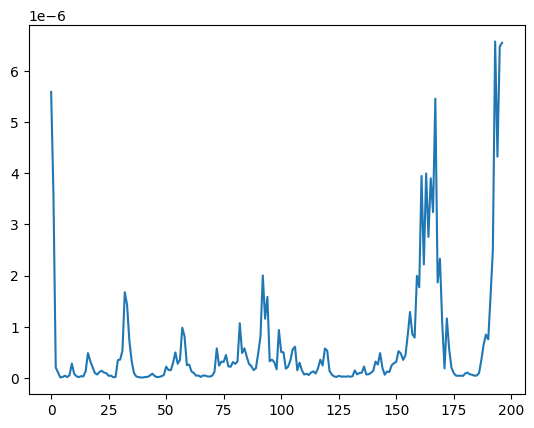

In [16]:
import IPython
import torch

import numpy as np
import pydub

def write_mp3(
  x,
  f="audio.mp3",
  sr=hp.sr,
  normalized=True
):
  """numpy array to MP3"""
  channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
  if normalized:  # normalized array - each item should be a float in [-1, 1)
      y = np.int16(x * 2 ** 15)
  else:
      y = np.int16(x)
  song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
  song.export(f, format="mp3", bitrate="320k")

train_saved_path = "/content/drive/MyDrive/Text_to_Speech/model-tts/train_SimpleTransfromerTTS.pt"
state = torch.load(train_saved_path)
model = TransformerTTS().cuda()
model.load_state_dict(state["model"])

text = "Onece upon a time there was king and a queen"
name_file = "hello_world.mp3"


postnet_mel, gate = model.inference(
  text_to_seq(text).unsqueeze(0).cuda(),
stop_token_threshold=1e-5,
  with_tqdm = False
)

audio = inverse_mel_spec_to_wav(postnet_mel.detach()[0].T)

plt.plot(
    torch.sigmoid(gate[0, :]).detach().cpu().numpy()
)

write_mp3(
    audio.detach().cpu().numpy(),
    name_file
)

IPython.display.Audio(
    audio.detach().cpu().numpy(),
    rate=hp.sr
)